# Введение

Пейзажная привлекательность - один из факторов развития территории, привлекающий туристов и "новых сельских" жителей. Но оказывает ли пейзаж влияние развитие территории? В нашем исследовании мы пытаемся это выяснить. 

Почему Тверская область? Это регион, зажатый между двумя крупнейшими экономическими центрами России - Москвы и Санкт-Петербурга. Сегодня этот регион относится к депрессивным. Однако в силу своего географического положения и исторической значимости он обладает значительным потенциалом для развития внутреннего историко-культурного и ландшафтного туризма.

Мы типологизировали муниципальные образования регионов по двум интегральным характеристикам: пейзажной привлекательности и уровню экономического развития. Сравнение типологий позволило выявить, насколько на современном этапе использован пейзажный потенциал.

Далее был проведен импорт необходимых библиотек

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import tempfile
import os
import rasterio
import statsmodels.api as sm
from rasterstats import zonal_stats 
from whitebox import WhiteboxTools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from shapely.ops import unary_union
from shapely.geometry import shape
import json
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных и подготовка

Одним из членов команды вручную были проанализированы и отобраны данные, предоставленные Сбером, и данные БДМО:

In [2]:
current_dir = os.getcwd()

In [3]:
bdmo = pd.read_excel(os.path.join(current_dir, r'Данные\БДМО\Хакатон_БДПМО_итог.xlsx'), sheet_name = 0)
sber = pd.read_excel(os.path.join(current_dir, r'Данные\Сбер_после_отбора\Хакатон_СБЕР_свод.xlsx'), sheet_name = 0)

Так же из  данных, предоставленных Сбером, были взяты пространственные данные и выбраны только границы Тверской области.

In [4]:
data_geo = gpd.read_file(os.path.join(current_dir, r'Данные\Исходные_данные_Сбер\Данные_пространственные\t_dict_municipal_districts_poly.gpkg'))
data_xlx = pd.read_excel(os.path.join(current_dir, r'Данные\Исходные_данные_Сбер\Данные_пространственные\t_dict_municipal_districts.xlsx'), sheet_name = 'Sheet1')

Один из членов команды заранее собрал необходимые ОКТМО для анализа.

In [5]:
oktmo = pd.read_excel(os.path.join(current_dir, r'Данные\ОКТМО_для_анализа\ОКТМО_Хакатон.xlsx'), sheet_name = 'Лист3')

In [6]:
data_xlx['oktmo_norm'] = data_xlx['oktmo'].str.replace('-', '').str[:-3].astype('int64')

In [7]:
data_xlx_tver = data_xlx[data_xlx['oktmo_norm'].isin(oktmo[oktmo['region_name'] == 'Тверская область']['oktmo'])]
data_xlx_tver = data_xlx_tver[['municipal_district_name_short', 'oktmo_norm', 'territory_id']]

In [8]:
data_xlx_tver = data_xlx_tver.drop(index = 2101) # Удаление Повтора
data_xlx_tver = data_xlx_tver.reset_index(drop = True)

In [9]:
data_geo['territory_id'] = data_geo['territory_id'].astype('int64')

In [10]:
gdf = data_geo.merge(data_xlx_tver, on = 'territory_id', how = 'inner')
gdf = gdf[gdf['territory_id'] !=2101] # Удаление Твери

# Получение индекса пейзажности

В рамках работы проводился расчет индекса пейзажности, котрый представлял собой интегральный индекс, рассчитанный из:
- перепада высот
- средней высоты
- протяженности береговой линии
- протяженности рек
- ландшафтного разнообразия
- количества объектов кульутрного наследия
- крутизны склонов
- высоты склонов
- топографического индекса влажности

В рамках работы предполагается, что наиболее разнообразная, открытая и пересеченная местность является наиболее визуально и рекреационно привлекательной.

## Расчет рельефных переменных

В качестве рельефных переменных рассматривались высота над уровнем моря, крутизна склонов, высота склонов, топографический индекс влажности. За основу рельефа была взята модель GTOPO2010 разрешением 7.5 arcsec, источник - [Earthexplorer USGS](https://earthexplorer.usgs.gov/). 

In [11]:
with rasterio.open(os.path.join(current_dir, r'Данные\Рельеф\rel_clip.tif')) as src:
    dem = src.read(1)
    affine = src.transform
    crs = src.crs
    nodata = src.nodata

Расчет переменных на основе ячеек растра

In [12]:
# Рассчет площади ячейки
cell_area = abs(affine[0]) * abs(affine[4])

with tempfile.TemporaryDirectory() as tmpdir:
    wbt = WhiteboxTools()
    wbt.work_dir = tmpdir
    
    # Сохранение DEM
    dem_path = os.path.join(tmpdir, "dem.tif")
    with rasterio.open(dem_path, 'w', driver='GTiff', 
                      height=dem.shape[0], width=dem.shape[1],
                      count=1, dtype=dem.dtype, crs=crs, 
                      transform=affine, nodata=nodata) as dst:
        dst.write(dem, 1)
    
    # Гидрологическая коррекция
    filled_path = os.path.join(tmpdir, "filled.tif")
    wbt.fill_depressions(dem_path, filled_path)
    
    # Расчет уклона в градусах
    slope_deg_path = os.path.join(tmpdir, "slope_deg.tif")
    wbt.slope(filled_path, slope_deg_path, units="degrees")
    
    # Расчет топографического индекса
    slope_rad_path = os.path.join(tmpdir, "slope_rad.tif")
    wbt.slope(filled_path, slope_rad_path, units="radians")
    
    d8_path = os.path.join(tmpdir, "d8.tif")
    wbt.d8_pointer(filled_path, d8_path)
    
    acc_path = os.path.join(tmpdir, "accumulation.tif")
    wbt.d8_flow_accumulation(filled_path, acc_path)
    
    acc_m2_path = os.path.join(tmpdir, "accumulation_m2.tif")
    wbt.multiply(acc_path, cell_area, acc_m2_path)
    
    twi_path = os.path.join(tmpdir, "twi.tif")
    wbt.wetness_index(acc_m2_path, slope_rad_path, twi_path)
    
    # Чтение результатов
    with rasterio.open(slope_deg_path) as src:
        slope = src.read(1)
    
    with rasterio.open(twi_path) as src:
        twi = src.read(1)
        affine_twi = src.transform


.\whitebox_tools.exe --run="FillDepressions" --wd="C:\Users\dmitr\AppData\Local\Temp\tmpfyfq0ur_" --dem='C:\Users\dmitr\AppData\Local\Temp\tmpfyfq0ur_\dem.tif' --output='C:\Users\dmitr\AppData\Local\Temp\tmpfyfq0ur_\filled.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 12%
Finding pit cells: 25%
Finding pit cells: 37%
Finding pit cells: 50%
Finding pit cells: 62%
Finding pit cells: 75%
Finding pit cells: 87%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depressions: 14%
Filling de

In [13]:
# Обработка бесконечных значений
twi = np.nan_to_num(twi, nan=0, posinf=0, neginf=0)

Отработка разницы высот по муниципальным районам

In [14]:
# 1. Разница высот (max-min) и средняя высота для исходного DEM
stats_dem = zonal_stats(
    gdf, 
    dem, 
    affine=affine, 
    stats=['min', 'max', 'mean'], 
    nodata=nodata
)
gdf['elev_min'] = [s['min'] for s in stats_dem]
gdf['elev_max'] = [s['max'] for s in stats_dem]
gdf['elev_diff'] = gdf['elev_max'] - gdf['elev_min']
gdf['elev_mean'] = [s['mean'] for s in stats_dem]

Отработка высоты склонов по муниципальным районам

In [15]:
slope_mask = slope > 2.0

# Применяем маску к DEM: оставляем только высоты на склонах
dem_slopes = np.where(slope_mask, dem, np.nan)

# Рассчитываем среднюю высоту склонов для каждого полигона
stats_slope_elev = zonal_stats(
    gdf, 
    dem_slopes, 
    affine=affine, 
    stats=['median'], 
    nodata=nodata
)
gdf['slope_elev_median'] = [s['median'] for s in stats_slope_elev]

Отработка разницы высот по муниципальным районам

In [16]:
stats_slope = zonal_stats(
    gdf, 
    slope, 
    affine=affine, 
    stats=['median'], 
    nodata=nodata
)
gdf['slope_median'] = [s['median'] for s in stats_slope]

Отработка топографического индекса влажности по муниципальным районам

In [17]:
stats_twi = zonal_stats(
    gdf, 
    twi, 
    affine=affine_twi, 
    stats=['median'], 
    nodata=nodata
)
gdf['twi_median'] = [s['median'] for s in stats_twi]

## Оценка ландшафтного разнообразия

В рамках оценки ландашфтного разнообразия использовался растр земельного покрытия/землепользования, подготовленный [Potapov, P., Hansen, M.C., Pickens, A., Hernandez-Serna, A., Tyukavina, A., Turubanova, S., Zalles, V., Li, X., Khan, A., Stolle, F. and Harris, N., 2022. The global 2000-2020 land cover and land use change dataset derived from the Landsat archive: first results. Front. Remote Sens. 3](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/download.html).

In [18]:
with rasterio.open(os.path.join(current_dir, r'Данные\Лендкавер\lulc_clip.tif')) as src_lc:
    landcover = src_lc.read(1)
    affine_lc = src_lc.transform
    nodata_lc = src_lc.nodata

In [19]:
def count_unique(x):
    filtered = x[x != nodata_lc]  
    return len(np.unique(filtered))

In [20]:
stats_landcover = zonal_stats(
    gdf,
    landcover,
    affine=affine_lc,
    stats=['count'],  
    add_stats={'unique': count_unique}, 
    nodata=nodata_lc
)

gdf['landcover_unique'] = [s['unique'] for s in stats_landcover]

## Расчет переменных водных объектов

Водные объекты являются важным фактором рекреационной атракции. В рамках работы рассчитывалась протяженность береговой линии и рек в пределах муниципалитетов. Источником являлась [OSM](https://download.geofabrik.de/), скачанный из открытого дистрибьютора пространственных данных Geofabric.

In [21]:
waterways = gpd.read_file(os.path.join(current_dir, r'Данные\Водные_объекты\gis_osm_waterways_free_1.shp'))
water = gpd.read_file(os.path.join(current_dir, r'Данные\Водные_объекты\gis_osm_water_a_free_1.shp'))

Из всего набора данных анализировались категории "озера", "пруды и водохранилища", "заливы". Из водотоков анализировались только "реки". 

In [22]:
water = water[water['fclass'].isin(['water', 'reservoir', 'riverbank'])]
waterways = waterways[waterways['fclass'].isin(['river'])]

In [23]:
def calculate_water_metrics(gdf, water_gdf, rivers_gdf):
    water_per_list = []
    rivers_len_list = []
    
    # Предварительная фильтрация водных объектов и рек
    water_geoms = water_gdf.geometry.tolist()
    rivers_geoms = rivers_gdf.geometry.tolist()
    
    for poly in gdf.geometry:
        # Расчет периметра водных объектов
        water_perimeter = 0
        for water_geom in water_geoms:
            if poly.intersects(water_geom):
                clipped = poly.intersection(water_geom)  # Аналог clip
                water_perimeter += clipped.length
        water_per_list.append(water_perimeter)
        
        # Расчет длины рек
        rivers_length = 0
        for river_geom in rivers_geoms:
            if poly.intersects(river_geom):
                if river_geom.geom_type == 'LineString':
                    clipped = poly.intersection(river_geom)
                    rivers_length += clipped.length
                elif river_geom.geom_type == 'MultiLineString':
                    for line in river_geom.geoms:
                        if poly.intersects(line):
                            clipped = poly.intersection(line)
                            rivers_length += clipped.length
        rivers_len_list.append(rivers_length)
    
    gdf['water_per'] = water_per_list
    gdf['rivers_len'] = rivers_len_list
    
    return gdf

In [24]:
gdf = calculate_water_metrics(gdf, water, waterways)

## Расчет количества ОКН

Объекты культурного наследния традиционно приквлекают рекреантов и составляют важную часть пейзажного облика территории. Источником для ОКН являлся [реестр ОКН](https://opendata.mkrf.ru/opendata/7705851331-egrkn/)

In [25]:
okn = pd.read_csv(os.path.join(current_dir, r'Данные\Данные_ОКН\data-63-structure-13.csv'))

In [26]:
okn = okn.dropna(subset = ['На карте'])
okn = okn[okn['Регион'] == 'Тверская область']

In [27]:
def parse_geojson(geo_str):
    try:
        return shape(json.loads(geo_str))
    except:
        return None

In [28]:
okn['geometry'] = okn['На карте'].apply(parse_geojson)
okn_gdf = gpd.GeoDataFrame(okn, geometry='geometry', crs="EPSG:4326")

okn_gdf = okn_gdf[okn_gdf.geometry.notna() & okn_gdf.geometry.is_valid]

In [29]:
def count_points_in_all_polygons(gdf, points_gdf):
    polygons = gdf.geometry.tolist()
    points = points_gdf.geometry.tolist()
    
    counts = []
    for poly in polygons:
        count = 0
        for point in points:
            if poly.intersects(point):
                count += 1
        counts.append(count)
    
    gdf['okn_count'] = counts
    return gdf

In [30]:
gdf = count_points_in_all_polygons(gdf, okn_gdf)

## Расчет индекса

Далее был рассчитан индекс пейзажности. Его расчет основывался на получении среднего арифметического значения анализируемых показателей. 

In [31]:
cols = ['elev_diff', 'elev_mean', 'slope_elev_median', 
        'slope_median', 'twi_median', 'landcover_unique', 'water_per', 'rivers_len', 'okn_count']

scaler = MinMaxScaler()
gdf[[f"{c}_sc" for c in cols]] = scaler.fit_transform(gdf[cols])

In [32]:
gdf['index'] = (gdf['elev_diff_sc'] + gdf['elev_mean_sc'] + gdf['slope_elev_median_sc']  + gdf['twi_median_sc'] + gdf['landcover_unique_sc']
                + gdf['water_per_sc'] + gdf['rivers_len_sc'] + gdf['okn_count_sc']) / 8

## Кластеризация переменных пейзажности

Так же в рамках работы была проведена кластеризация муниципальных образований по пейзажным переменным. Кластеризация была проведена в целях определения групп типов пейзажности в целях возможности сопоставления пейзажности с экономическими показателями.

In [33]:
gdf_cluster = gdf[['territory_id', 'elev_diff', 'elev_mean',
       'slope_elev_median', 'twi_median', 
     'landcover_unique', 'water_per', 'rivers_len', 'okn_count']].set_index('territory_id')

### Определение оптимального числа кластеров

В целях определения оптимального числа кластеров был посчитан коэффициент силуэта - мера перекрытия внутри кластеров. Число кластеров с наибольщим значением коэффициента силуэта предполагается за оптимальное число

In [34]:
silhouette_scores = []
K = range(3, 18)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(gdf_cluster)
    score = silhouette_score(gdf_cluster, model.labels_)
    silhouette_scores.append(score)

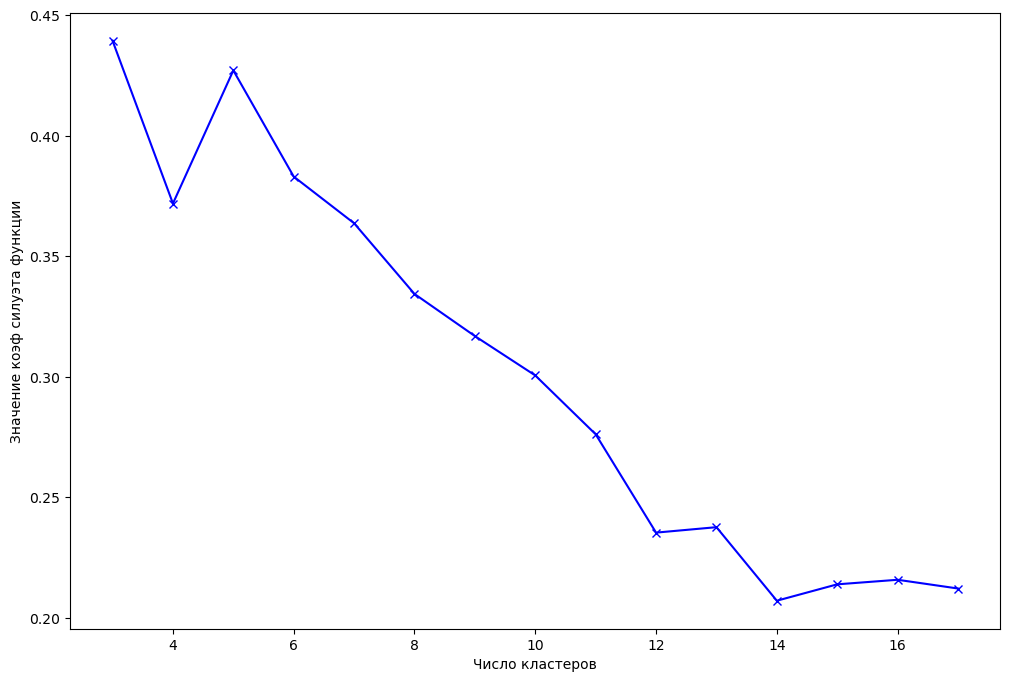

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение коэф силуэта функции')
plt.show() 

### Кластеризация

Кластеризация включала в себя собственно кластеризацию муниципалитетов и определение центров кластеров

In [36]:
model = KMeans(n_clusters=4, random_state=12345)
model.fit(gdf_cluster)
predicts  = model.predict(gdf_cluster)

In [37]:
df = pd.DataFrame(model.cluster_centers_, columns=gdf_cluster.columns)
gdf['preds'] = predicts
df['index'] = gdf.pivot_table(index = 'preds', values = 'index', aggfunc = 'median')['index']

## Анализ кластеризации

На основе центров кластеров и сопоставлении центров кластеров был проведен анализ полученных кластеров. 

In [38]:
df

,elev_diff,elev_mean,slope_elev_median,twi_median,landcover_unique,water_per,rivers_len,okn_count,index
0,98.500000,200.644735,198.500000,-3.022140,73.500000,7.847015,3.206461,214.500000,0.473286
1,111.800000,168.699038,178.333333,-3.043428,72.600000,4.148249,4.568439,9.666667,0.282677
2,164.714286,219.420407,222.357143,-3.263254,76.642857,4.881108,6.661700,40.214286,0.488577
3,99.666667,139.933456,143.666667,-2.842768,76.666667,12.258913,6.480493,52.500000,0.352648


In [39]:
for pred in gdf['preds'].sort_values().unique():
    print(f'Кластер {pred} содержит следующие муниципалитеты: {", ".join(gdf[gdf["preds"] == pred]["municipal_district_name_short"])} \n')

Кластер 0 содержит следующие муниципалитеты: Торжок, Осташковский 

Кластер 1 содержит следующие муниципалитеты: Спировский, Сонковский, Сандовский, Рамешковский, Молоковский, Максатихинский, Лихославльский, Лесной, Краснохолмский, Кесовогорский, Западнодвинский, Жарковский, Весьегонский, Бологовский, Удомельский 

Кластер 2 содержит следующие муниципалитеты: Торопецкий, Торжокский, Старицкий, Селижаровский, Ржевский, Пеновский, Оленинский, Нелидовский, Зубцовский, Вышневолоцкий, Бельский, Андреапольский, Фировский, Кувшиновский 

Кластер 3 содержит следующие муниципалитеты: Конаковский, Кимрский, Кашинский, Калязинский, Калининский, Бежецкий 



In [40]:
gdf.columns

Index(['osm_ref', 'osm_vers', 'territory_id', 'year_from', 'year_to',
       'geometry', 'municipal_district_name_short', 'oktmo_norm', 'elev_min',
       'elev_max', 'elev_diff', 'elev_mean', 'slope_elev_median',
       'slope_median', 'twi_median', 'landcover_unique', 'water_per',
       'rivers_len', 'okn_count', 'elev_diff_sc', 'elev_mean_sc',
       'slope_elev_median_sc', 'slope_median_sc', 'twi_median_sc',
       'landcover_unique_sc', 'water_per_sc', 'rivers_len_sc', 'okn_count_sc',
       'index', 'preds'],
      dtype='object')

Анализ показывает, что кластер 2 является лидером по индексу пейзжаности, что обеспечивается за счет высокой пересеченности рельефа, наличия протяженной береговой линии. Кластер 0 так же является одним из лидеров по пейзажности, дополняя пейзажность объектами культурного наследия. Кластер 3 представлен как средне-пейзажный, лидирует по показателю разнообразия ландшафтов. КЛастер 1 является наименее пейзажно-привлекательным, отставая по большинству показателей.

# Анализ социально-экономических данных муниципалитетов

## Предобработка

В рамках предобработки были приведены к единому формату колонки в данных, выбраны только необходимые (без технических) колонки в БДМО, объеденины таблицы, отработаны пропуски, убрана Тверь.

In [41]:
bdmo = bdmo[['municipality', 'oktmo', 'otgruzka', 'org_num_2024', 'ip_num_2024', 'tourists', 'trade']]

In [42]:
gdf = gdf.rename(columns = {'oktmo_norm':'oktmo'})

In [43]:
gdf = gdf.merge(bdmo, on = 'oktmo', how = 'left')
gdf = gdf.merge(sber, on = 'territory_id', how = 'left')

In [44]:
gdf = gdf[gdf['territory_id'] !=2101] #Исключение Твери

In [45]:
gdf.isna().sum()

osm_ref                           0
osm_vers                          0
territory_id                      0
year_from                         0
year_to                           0
geometry                          0
municipal_district_name_short     0
oktmo                             0
elev_min                          0
elev_max                          0
elev_diff                         0
elev_mean                         0
slope_elev_median                 0
slope_median                      0
twi_median                        0
landcover_unique                  0
water_per                         0
rivers_len                        0
okn_count                         0
elev_diff_sc                      0
elev_mean_sc                      0
slope_elev_median_sc              0
slope_median_sc                   0
twi_median_sc                     0
landcover_unique_sc               0
water_per_sc                      0
rivers_len_sc                     0
okn_count_sc                

In [46]:
gdf['tourists'] = gdf['tourists'].fillna(0)
gdf['trade'] = gdf['trade'].fillna(gdf['trade'].median())
gdf['consumption'] = gdf['consumption'].fillna(gdf['consumption'].median())

## Получение новых переменных

В целях проведения анализа все переменные были приведены к населению (в единицах и тысячах в зависимости от размерности)

In [47]:
gdf['consumption_per_pop'] = gdf['consumption']/ gdf['population_sber']
gdf['otgruzka_per_pop'] = gdf['otgruzka']/ gdf['population_sber']
gdf['trade_per_pop'] = gdf['trade']/ gdf['population_sber']
gdf['migration_saldo_sber_per_pop'] = gdf['migration_saldo_sber']/ (gdf['population_sber'] / 1000)
gdf['org_num_2024_per_pop'] = gdf['org_num_2024']/ (gdf['population_sber'] / 1000)
gdf['ip_num_2024_sber_per_pop'] = gdf['ip_num_2024']/ (gdf['population_sber'] / 1000)
gdf['tourists_per_pop'] = gdf['tourists']/ (gdf['population_sber'] / 1000)

## Исследовательский анализ данных

Исследовательский анализ данных предполагал изучение переменных на основе графиков

In [48]:
columns_to_research = ['otgruzka_per_pop', 'org_num_2024_per_pop', 'ip_num_2024_sber_per_pop', 'tourists_per_pop',
       'trade_per_pop', 'migration_saldo_sber_per_pop', 'population_sber', 'salary_av_sber', 'consumption_per_pop']

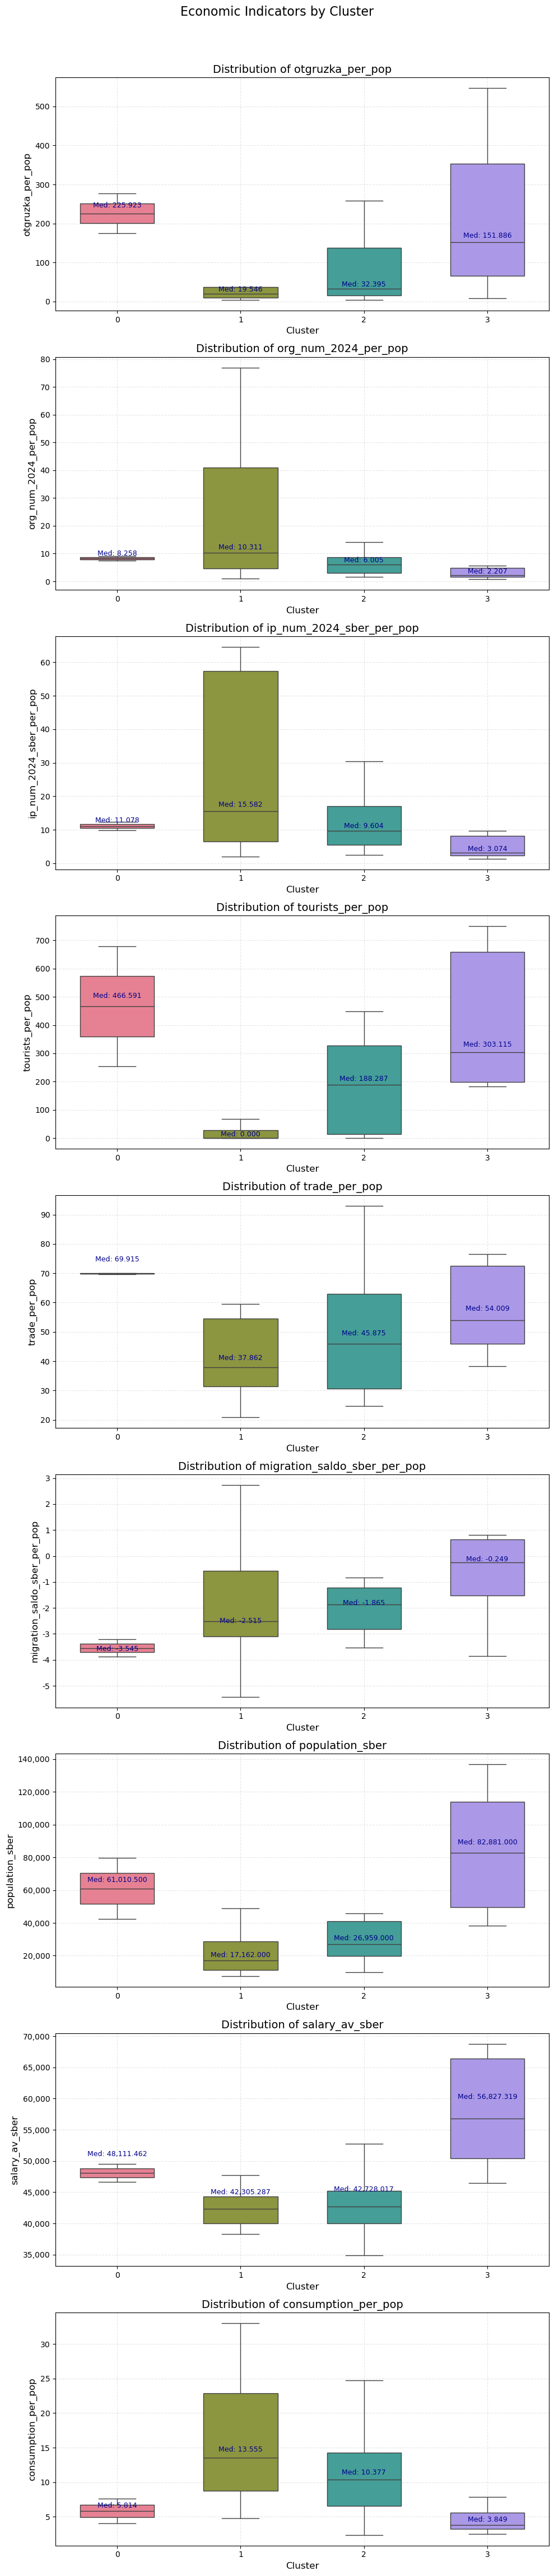

In [49]:
n_clusters = gdf['preds'].nunique()
cluster_palette = sns.color_palette("husl", n_colors=n_clusters)

fig, axes = plt.subplots(len(columns_to_research), 1, 
                         figsize=(10, 5*len(columns_to_research)))

# Если только один показатель, преобразуем axes в массив
if len(columns_to_research) == 1:
    axes = [axes]

# Проходим по всем числовым столбцам
for i, col in enumerate(columns_to_research):
    ax = axes[i]
    
    # Строим чистый боксплот
    sns.boxplot(
        data=gdf,
        x='preds',
        y=col,
        palette=cluster_palette,
        ax=ax,
        showfliers=False,  # Показываем выбросы
        width=0.6
    )
    
    # Настройка оформления
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(col, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Форматирование чисел на оси Y
    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Добавляем аннотации с базовой статистикой
    cluster_medians = gdf.groupby('preds')[col].median().reset_index()
    for j, row in cluster_medians.iterrows():
        ax.text(
            j, 
            row[col] * 1.05,  # Немного выше медианы
            f'Med: {row[col]:,.3f}',
            ha='center',
            va='bottom',
            fontsize=9,
            color='darkblue'
        )

plt.tight_layout()
plt.suptitle('Economic Indicators by Cluster', fontsize=16, y=1.02)
plt.show()

Анализ графиков показал, что районы с высоким ландшафтным разнообразием и высокой концентрацией культурного наследния выделяются высокими показателями социально-экономического развития: отгруженной продукцией, потребительскими расходами, душевым оборотом розничной торговли и доходами населения. Данное обстоятельство связано с более активным использованием туристического потенциала за счет наличия исторического наследия, выгодного расположения и развитого промышленного потенциала, в частности в Вышневолоцком и Торжокском муниципальных районах. 

Также, была выделена группа с высоким ландшафтным разнообразием, социально-экономические показатели которых относительно низки. Это связано в целом с низкой экономической активностью, невысокой численностью населения и при этом изолированностью от крупных магистралей и транспортных путей. 

## Кластеризация социально-экономических показателей

In [50]:
filtered_columns = [col for col in columns_to_research if col not in ['org_num_2024_per_pop', 'ip_num_2024_sber_per_pop']]

gdf_cluster = gdf[['territory_id', *filtered_columns]].set_index('territory_id')

### Определение оптимального числа кластеров

В целях определения оптимального числа кластеров был посчитан коэффициент силуэта - мера перекрытия внутри кластеров. Число кластеров с наибольщим значением коэффициента силуэта предполагается за оптимальное число

In [51]:
silhouette_scores = []
K = range(3, 18)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(gdf_cluster)
    score = silhouette_score(gdf_cluster, model.labels_)
    silhouette_scores.append(score)

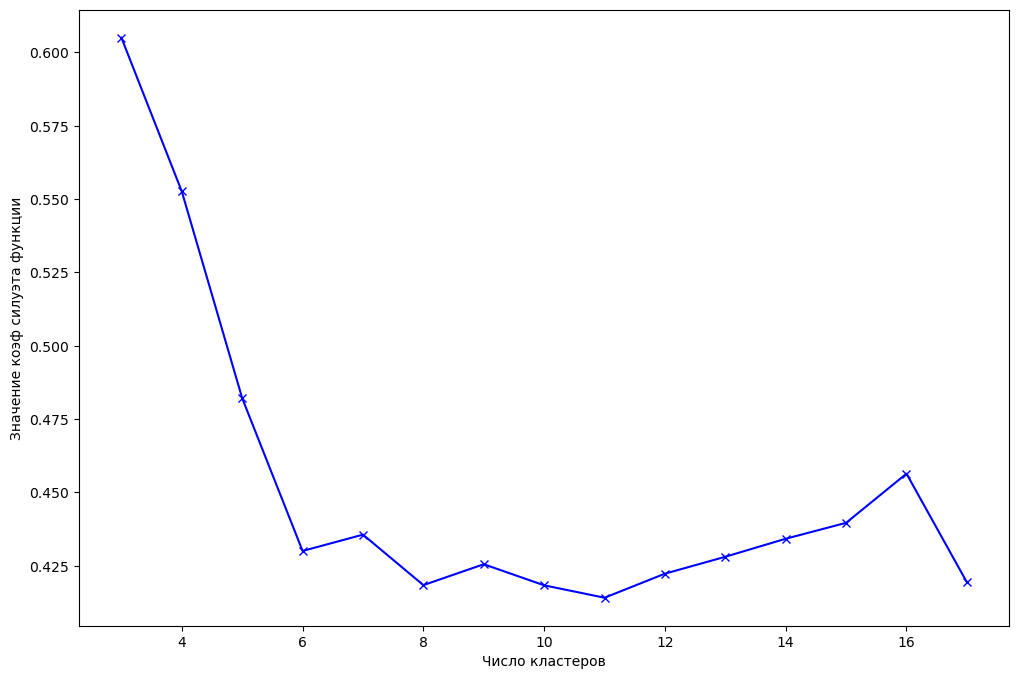

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение коэф силуэта функции')
plt.show() 

### Кластеризация

Кластеризация включала в себя собственно кластеризацию муниципалитетов и определение центров кластеров

In [53]:
model = KMeans(n_clusters=3, random_state=12345)
model.fit(gdf_cluster)
predicts  = model.predict(gdf_cluster)

In [54]:
df = pd.DataFrame(model.cluster_centers_, columns=gdf_cluster.columns)
gdf['preds_soc'] = predicts

## Анализ кластеризации

На основе центров кластеров и сопоставлении центров кластеров был проведен анализ полученных кластеров. 

In [55]:
df

,otgruzka_per_pop,tourists_per_pop,trade_per_pop,migration_saldo_sber_per_pop,population_sber,salary_av_sber,consumption_per_pop
0,214.528091,301.465047,55.807978,-2.525932,51180.181818,49093.427645,5.963524
1,254.816899,677.275881,92.746940,2.418014,123153.800000,57346.885347,2.758486
2,63.354036,76.189080,58.073617,-2.386495,18108.761905,41553.866520,17.425799


In [56]:
for pred in gdf['preds_soc'].sort_values().unique():
    print(f'Кластер {pred} содержит следующие муниципалитеты: {", ".join(gdf[gdf["preds"] == pred]["municipal_district_name_short"])} \n')

Кластер 0 содержит следующие муниципалитеты: Торжок, Осташковский 

Кластер 1 содержит следующие муниципалитеты: Спировский, Сонковский, Сандовский, Рамешковский, Молоковский, Максатихинский, Лихославльский, Лесной, Краснохолмский, Кесовогорский, Западнодвинский, Жарковский, Весьегонский, Бологовский, Удомельский 

Кластер 2 содержит следующие муниципалитеты: Торопецкий, Торжокский, Старицкий, Селижаровский, Ржевский, Пеновский, Оленинский, Нелидовский, Зубцовский, Вышневолоцкий, Бельский, Андреапольский, Фировский, Кувшиновский 



Наибольшим уровнем социально-экономического развития выделяются районы, располагающиеся на юго-востоке области и входящие во влияние московской агломерации. 

## Регрессионный анализ

В рамках регрессионного анализа была проверена гипотеза о наличии статистически значимой зависимости между пейзажностью и социально-экономическими показателями. В рамках расчетов были получены p-value, r2 и остатки. 

In [57]:
p_values = []
coefs = []
r_sq = []
reds = []

for column in columns_to_research:
    X = gdf['index']
    y = gdf[column]
    
    model = sm.OLS(y, X).fit()
    
    p_values.append(model.pvalues[0])
    coefs.append(model.params[0])
    r_sq.append(model.rsquared)
    reds.append(model.resid.mean())

In [58]:
df_model = pd.DataFrame({'column': columns_to_research, 'beta-coef': coefs, 'p-values': p_values, 'r_sq': r_sq, 'residuials_med': reds})

In [59]:
df_model

,column,beta-coef,p-values,r_sq,residuials_med
0,otgruzka_per_pop,320.023206,1.819576e-03,0.239499,8.915911
1,org_num_2024_per_pop,31.280920,3.537949e-02,0.117209,4.674670
2,ip_num_2024_sber_per_pop,51.719145,2.142538e-02,0.138453,6.985026
3,tourists_per_pop,613.002017,3.887775e-05,0.379022,-15.534273
4,trade_per_pop,139.614536,3.859152e-07,0.515698,7.441359
5,migration_saldo_sber_per_pop,-3.898780,2.255880e-02,0.136274,-0.252732
6,population_sber,106424.475944,4.633852e-09,0.619424,482.193059
7,salary_av_sber,105928.800101,4.511247e-18,0.878738,4469.665866
8,consumption_per_pop,25.334556,7.674858e-07,0.497303,2.120237


Анализ полученных результатов показал отсутствие статистически значимой зависимости между показателями, что позволяет сделать следующий вывод: мера пейзажности является мерой потенциала привлекательности территории, ее дальнейшее изучение требует включения дополнительных социально-экономических показателей. 

# Выгрузка результатов

In [61]:
gdf.to_file(os.path.join(current_dir, r'Выгрузка\tver_view.gpkg'), encoding = 'utf-8')

Более высоким пейзажным потенциалом отличаются районы западной части области, расположенные на Валдайской возвышенности. Наибольшей "пейзажностью" отличается Осташковский район вокруг Селигера. Средним уровнем отличаются районы вдоль Волги. 

Более высоким уровнем экономического развития отличаются районы, прилегающие к Твери и входящие в зону воздействия Московской агломерации. Периферийные районы востока и запада области отличаются низким уровнем развития. 

Сопоставление двух кластеризаций показывает, что пейзажная привлекательность может поддерживать экономическое развитие, но не является ведущим фактором. Оно выступает в качестве дополнительного фактора только при условии отсутствия барьеров и выгодного ЭГП. Для полного использования пейзажного потенциала неоьходимо снятие ограничений, в первую очередь инфраструктурных.